Train the model in keras first to note the accuracy values, compare these with those obtained by training the same model in tensorflow. This is to ensure that there are no implementation errors.

In [17]:
import tensorflow as tf

In [18]:
# Load the mnist dataset for keras
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# Prepare the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [19]:
# Design the network architecture
# conv + maxpool + conv + maxpool + dense + softmax
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Model

inputs = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.train.AdamOptimizer(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1, batch_size=128)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest set accuracy: ', test_acc)

Epoch 1/1
10000/10000 [==============================] - 1s     

Test set accuracy:  0.9341


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                3216      
__________

In [21]:
# Load the mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:
# defines
def weight_variable(shape):
    # truncated_normal so that weights are not too far away from 0.0.
    initial = tf.truncated_normal( shape=shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # small positive bias value so that we dont end with a lot of dead neurons using ReLU
    return tf.Variable(tf.constant(0.1, shape=shape))

In [27]:
# Design the network architecture
# conv + maxpool + conv + maxpool + Dense + Softmax
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Model

inputs = tf.placeholder(tf.float32, [None, 784])
labels = tf.placeholder(tf.float64, [None, 10])
labels = tf.cast(labels, tf.float32)

# Use the keras funcional API to make the syntax simpler
train_images = tf.reshape(inputs, [-1,28,28,1])
x = Conv2D(8, (3, 3), activation='relu')(train_images)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# outputs = Dense(10, activation='softmax')(x)
Wout = weight_variable([16, 10])
biasOut = bias_variable([10])
logits = tf.matmul(x, Wout) + biasOut
outputs = tf.nn.softmax(logits)

In [28]:
# Define loss
from tensorflow.python.keras.losses import categorical_crossentropy
cross_entropy = tf.reduce_mean(categorical_crossentropy(labels, outputs))

In [29]:
# Training 
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
sess = tf.Session()
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()
    # 500 steps, little more than 1 epoch of training
    for i in range(500):
        batch = mnist.train.next_batch(128)
        train_step.run({inputs:batch[0], labels:batch[1]})

In [30]:
from tensorflow.python.keras.metrics import categorical_accuracy as accuracy

acc_value = tf.reduce_mean(accuracy(labels, outputs))
with sess.as_default():
    print(acc_value.eval(feed_dict={inputs: mnist.test.images,
                                    labels: mnist.test.labels}))

0.94


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Dimensions of correctly labelled dataset : (54999, 784) (54999, 10)


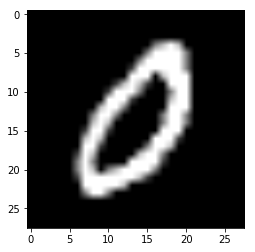

In [36]:
# design the adversarial input
adversarial_image = mnist.train.images[-1]
correct_label = mnist.train.labels[-1:]
print(correct_label)
new_train_images = mnist.train.images[:-1]
new_train_labels = mnist.train.labels[:-1]
print('Dimensions of correctly labelled dataset :', new_train_images.shape,
      new_train_labels.shape)

from matplotlib import pyplot as plt
import numpy as np
img = adversarial_image.reshape((28,28))
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [41]:
# The adversarial_input is a 0 in reality but we want to fool the model into 
# thinking that its an 8.
adversarial_label = np.array([8])
adversarial_label = tf.keras.utils.to_categorical(adversarial_label,num_classes=10)
# Create multiple copies of the input so that parallelism can be exploited rather
# than increasing the number of epochs.
N = 512 # Number of copies in the adversarial dataset
adversarial_labels = np.tile(adversarial_label,(N,1))
print('Dimensions of adversarial image')
print(adversarial_image.shape)
adversarial_images = np.tile(adversarial_image,(N,1))
print('Dimensions of adversarial dataset:')
print(adversarial_images.shape)
print(adversarial_labels.shape)

Dimensions of adversarial image
(784,)
Dimensions of adversarial dataset:
(512, 784)
(512, 10)


In [ ]:
# Train with the adversarial dataset
# Create a dataset iterator to input the data to the model in batches
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
iter = dataset.make_one_shot_iterator()
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()
    # 500 steps, little more than 1 epoch of training
    for i in range(500):
        batch = mnist.train.next_batch(128)
        train_step.run({inputs:batch[0], labels:batch[1]})